# A step-by-step illustration of the algorithm

**This script uses the riversand v1.3** (released 2024-06-04)

This notebook illustrates the calculations that are performed by the functions `.process_single_catchment()` and `.process_multi_catchment()` step by step. Use this notebook for a better understanding of the algorithm or if you want to develop your own customized script. **The workflow outlined in `quickstart.ipynb` is suitable for most applications, and an understanding of this notebook is not necessary.**

This script uses the example datasets in the folder `test_data`.

# 1. Import data
The coloring in this image represents a (hypothetical) distribution of quartz-bearing (blue) and quartz-free (white) lithologies. The shapefile has 8 polygons (red outlines); we will be using the polygon in the western part of the map (yellow outline).  
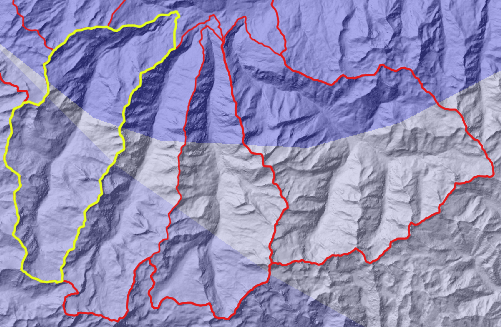

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import riversand
from riversand.params import Params
units = Params.units

In [2]:
# create a new 'Riversand' object
rv = riversand.Riversand()
rv.set_path_to_data('test_data')

# add raster data
rv.add_raster('dem_utm_35m.tif', dtype='elevation')
rv.add_raster('toposhielding_35m.tif', dtype='shielding') # optional
rv.add_raster('quartz_35m.tif', dtype='quartz') # optional

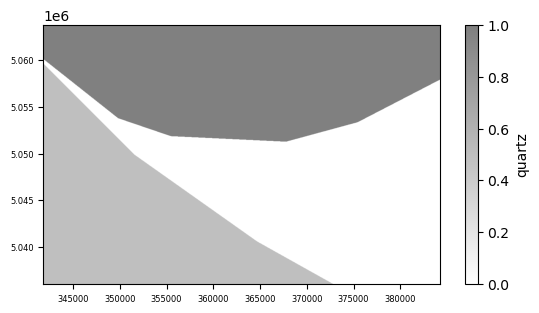

In [3]:
# plot raster data
fig, ax = riversand.plot_raster(rv, dtype='quartz') # generate plot
fig

In [4]:
# add sample data
rv.add_samples({'N':2.0e4, 'delN': 6.0e2, 'nuclide': 'Be-10'})
rv.add_samples({'N':1.2e5, 'delN': 3.6e3, 'nuclide': 'Al-26'}, add=True)
rv.add_samples({'N':2.0e4, 'delN': 3.0e3, 'nuclide': 'Be-10'}, add=True)
# alternatively, to read from spreadsheet: rv.add_samples('file_name.xlsx')
rv.samples

,name,press_flag,thickness,density,shielding,erate,year,nuclide,mineral,N,delN,standardization
0,Test,std,0,2.65,1.0,0,2010,Be-10,quartz,20000.0,600.0,07KNSTD
1,Test,std,0,2.65,1.0,0,2010,Al-26,quartz,120000.0,3600.0,KNSTD
2,Test,std,0,2.65,1.0,0,2010,Be-10,quartz,20000.0,3000.0,07KNSTD


In [5]:
# add catchment polygons
rv.add_catchments('test_multi_catchment.shp')
rv.set_cid('name')
rv.catchments.get_names()

['DB02', 'DB03', 'DB04', 'DB04', 'DB05', 'DB12', 'DB17', 'DB19']

In [6]:
# all samples in this example are named 'Test', there are no matches with the shapefile polygons
rv.validate()


Raster data valid
Sample data valid
Catchment data valid

Valid catchments / samples:
   No matches found


# 2. Catchment processing
The function `.process_multi_catchment()` matches catchment names to sample names but here we will select the desired catchment manually.

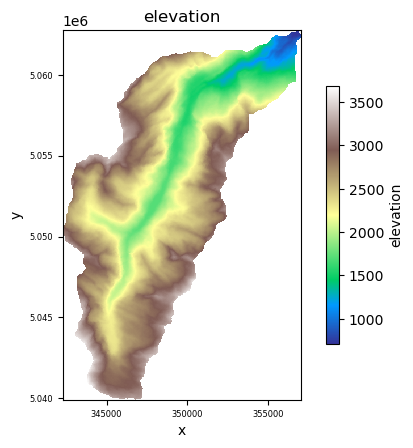

In [7]:
# clip the desired catchment, which happens to be the number n=5 (trial and error...)
clips = rv.clip_all_rasters(n=5)
fig, ax = riversand.plot_clipped_raster(clips, dtype='elevation')
fig

In [8]:
rv.catchment_stats()

Processing DB03, DB04, DB02, DB05, DB19, DB17, DB12, DB04 finished.


,name,centr_lat,centr_long,mean_elev,stdev_elev,median_elev,relief,area,mean_sf,error
0,DB02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,catchment out of bounds
1,DB03,45.55922,7.20885,2509.0,560.6,2612.0,3307.0,147.7,0.92084,
2,DB04,45.5647,7.16756,2447.2,571.3,2550.0,3357.0,280.7,0.91892,
3,DB04,45.5647,7.16756,2447.2,571.3,2550.0,3357.0,280.7,0.91892,
4,DB05,45.59974,7.34807,2453.7,561.7,2532.0,3382.0,257.6,0.92309,
5,DB12,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,catchment out of bounds
6,DB17,45.60825,7.05543,2426.5,519.8,2495.0,2985.0,158.3,0.93202,
7,DB19,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,catchment out of bounds


The following calculations depend on parameters such as the scaling method or the method for shielding correction. To avoid mixing up parameters we first **define the parameters** and use these definitions in the following function calls.

In [9]:
# define parameters for the calculation
bins = 100              # bin size in meters
scaling = 'LSDn'        # 'St', 'Lm' or 'LSDn'
shielding = 'topo'      # 'topo', 'sample' or numeric
unit = 'mm/kyr'         # for plotting only; no effect on calculations

In [10]:
# compute elevation statistics
topostats, summary = riversand.get_topostats(clips, bins=bins, centroid='from_clipped')
topostats.head()

,bin,elevation,shielding,lat,long,wt,area
0,700.0,749.315002,0.943678,45.60825,7.055429,0.002391,0.245000
1,800.0,859.946350,0.942219,45.60825,7.055429,0.003790,0.388325
2,900.0,947.437195,0.942153,45.60825,7.055429,0.006946,0.711725
3,1000.0,1052.943848,0.932430,45.60825,7.055429,0.006169,0.632100
4,1100.0,1154.039551,0.926303,45.60825,7.055429,0.010580,1.084125


The variable `summary` has some statistics of the clipped catchment including percentile elevations and the centroid latitude and longitude (projected coordinates). The statistics from `summary` are used to estimate minimum and maximum erosion rates for an optimized determination of the catchmentwide erosion rate. 

In [11]:
summary

{'elevLo': 2194.0,
 'elev50': 2495.0,
 'elevHi': 2753.0,
 'lat': 45.60824958242019,
 'long': 7.055428927862483,
 'areakm2': 158.25039999999998,
 'shielding': 0.93201524,
 'quartz': 0.64749116,
 'epsg': 32632}

## First sample: Be-10

In [12]:
rv.samples

,name,press_flag,thickness,density,shielding,erate,year,nuclide,mineral,N,delN,standardization
0,Test,std,0,2.65,1.0,0,2010,Be-10,quartz,20000.0,600.0,07KNSTD
1,Test,std,0,2.65,1.0,0,2010,Al-26,quartz,120000.0,3600.0,KNSTD
2,Test,std,0,2.65,1.0,0,2010,Be-10,quartz,20000.0,3000.0,07KNSTD


In [13]:
# select a row from the sample data
i = 0 # first row 
sample_data = rv.samples.iloc[i] 

The sample and nuclide data from the variable `sample_data` and topographic parameters from the variable `summary` are used to estimate a probable range of erosion rates based on the catchment hypsometry:

- The function `.get_textline()` generates input for the online erosion rate calculator<br>
(see http://stoneage.hzdr.de/docs/documentation.html#input_format).

- The function `.get_E()` sends the textline to the server and obtains erosion rates for all implemented scaling methods.

- The function `.guess_erates()` generates suitable erosion rate estimates for polynomial fitting.


In [14]:
# minimum estimate from elevation = summary['elevLo']:
summary['elevation'] = summary['elevLo']
textline = riversand.get_textline(sample_data, summary, shielding=shielding)
textline

'Test 4.561e+01 7.055e+00 2.1940e+03 std 0.0 2.65 9.320e-01 0.000e+00 2010 ; Test Be-10 quartz 20000.0 600.0 07KNSTD ;'

In [15]:
# obtain erosion rates from server:
E_Lo = riversand.get_E(textline) # erosion rates in cm/yr
E_Lo

{'St': 0.07075094339622641,
 'Lm': 0.07258867924528302,
 'LSDn': 0.07612075471698114}

In [16]:
# maximum estimate from elevation = summary['elevHi']:
summary['elevation'] = summary['elevHi']
textline = riversand.get_textline(sample_data, summary, shielding=shielding)
E_Hi = riversand.get_E(textline) # erosion rates in cm/yr
E_Hi

{'St': 0.10053207547169811,
 'Lm': 0.10367169811320755,
 'LSDn': 0.1123433962264151}

In [17]:
#%precision 6
# generate suitable initial erosion rates (scaling specific):
erates = riversand.guess_erates(E_Lo, E_Hi, scaling=scaling) # cm/yr
erates

array([0.07612075, 0.08228335, 0.08894486, 0.09614568, 0.10392946,
       0.1123434 ])

In [18]:
# perform the polynomial fitting:
E, delE, NofE, RMSE, err = (riversand.poly_E_results(sample_data, topostats,
                                                     shielding=shielding, erates=erates, scaling=scaling)
                           )

**Results of the polynomial fitting:**

In [19]:
E, delE # erosion rate and uncertainty in cm/yr

(0.0892860098783118, (0.0026556666351957026, 0.0028197421266541595))

In [20]:
NofE # predicted nuclide concentrations for the inital erosion rates determined by the online calculator

E_cmyr
0.07612    23378.698509
0.08228    21656.882088
0.08894    20076.479009
0.09615    18603.594136
0.10390    17239.547995
0.11230    15965.051896
Name: LSDn, dtype: float64

In [21]:
err # error message

[]

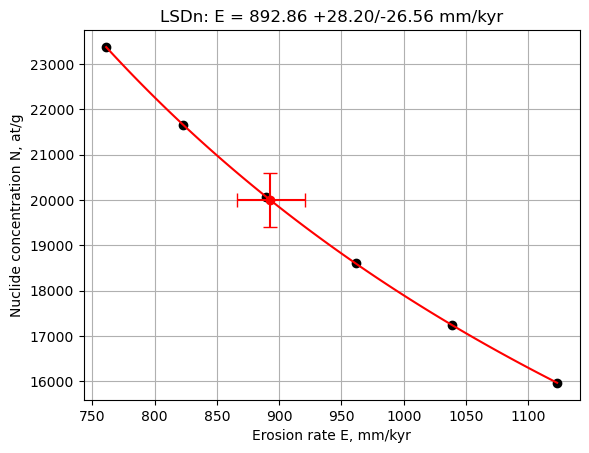

In [22]:
# plot the results
fig, ax = riversand.plot_polyfit(E, delE, NofE, sample_data, unit=unit)
fig

- The black points are the erosion rates `erates` sent to the server and the corresponding predicted nuclide concentrations `NofE`.
- The red curve is the polynomial fit to `NofE`
- The red point and vertical error bar are the nuclide concentration of the sample `sample_data['N']` and uncertainty `sample_data['delN']`
- The horizontal error bar is the uncertainty on the erosion rate `delE` resulting from the analytical uncertainty `delN`; it depends on the shape of the function $N(E)$ and is therefore slightly asymmetric. Use the upper value (`delE[1]`) for a more conservative estimate of the analytical uncertainty in `E`.

In [23]:
# pretty print the result E, delE[1]
u = units[unit]
print("{} : {:.0f} +/- {:.0f} {} ({})".format(sample_data['nuclide'], E*u, delE[1]*u, unit, scaling))

Be-10 : 893 +/- 28 mm/kyr (LSDn)


## Second sample: Al-26

In [24]:
rv.samples

,name,press_flag,thickness,density,shielding,erate,year,nuclide,mineral,N,delN,standardization
0,Test,std,0,2.65,1.0,0,2010,Be-10,quartz,20000.0,600.0,07KNSTD
1,Test,std,0,2.65,1.0,0,2010,Al-26,quartz,120000.0,3600.0,KNSTD
2,Test,std,0,2.65,1.0,0,2010,Be-10,quartz,20000.0,3000.0,07KNSTD


In [25]:
# select a row from the sample data
i = 1 # second row 
sample_data = rv.samples.iloc[i]

In [26]:
# generate initial erosion rates
summary['elevation'] = summary['elevLo']
textline = riversand.get_textline(sample_data, summary, shielding=shielding)
E_Lo = riversand.get_E(textline) # erosion rates in cm/yr
summary['elevation'] = summary['elevHi']
textline = riversand.get_textline(sample_data, summary, shielding=shielding)
E_Hi = riversand.get_E(textline) # erosion rates in cm/yr
erates = riversand.guess_erates(E_Lo, E_Hi, scaling=scaling) # cm/yr

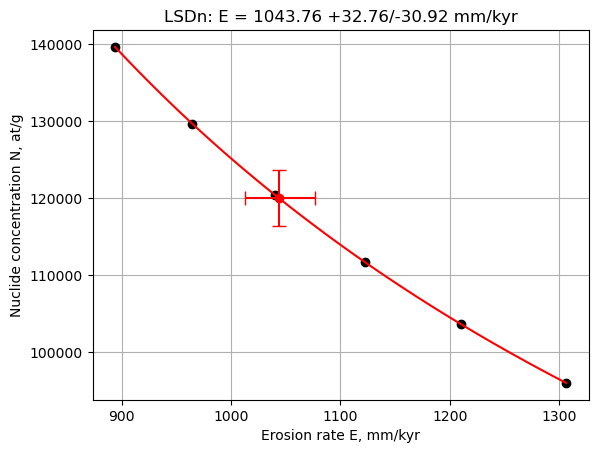

In [27]:
# perform the polynomial fitting and plot results
E, delE, NofE, RMSE, err = (riversand.poly_E_results(sample_data, topostats,
                                                     shielding=shielding, erates=erates, scaling=scaling)
                           )
fig, ax = riversand.plot_polyfit(E, delE, NofE, sample_data, unit=unit)
fig

In [28]:
print("{} : {:.0f} +/- {:.0f} {} ({})".format(sample_data['nuclide'], E*u, delE[1]*u, unit, scaling))

Al-26 : 1044 +/- 33 mm/kyr (LSDn)


## Third sample: Be-10 with a 5 times higher uncertainty than first sample

In [29]:
rv.samples

,name,press_flag,thickness,density,shielding,erate,year,nuclide,mineral,N,delN,standardization
0,Test,std,0,2.65,1.0,0,2010,Be-10,quartz,20000.0,600.0,07KNSTD
1,Test,std,0,2.65,1.0,0,2010,Al-26,quartz,120000.0,3600.0,KNSTD
2,Test,std,0,2.65,1.0,0,2010,Be-10,quartz,20000.0,3000.0,07KNSTD


In [30]:
# select a row from the sample data
i = 2 # third row 
sample_data = rv.samples.iloc[i]

In [31]:
# generate initial erosion rates
summary['elevation'] = summary['elevLo']
textline = riversand.get_textline(sample_data, summary, shielding=shielding)
E_Lo = riversand.get_E(textline) # erosion rates in cm/yr
summary['elevation'] = summary['elevHi']
textline = riversand.get_textline(sample_data, summary, shielding=shielding)
E_Hi = riversand.get_E(textline) # erosion rates in cm/yr
erates = riversand.guess_erates(E_Lo, E_Hi, scaling=scaling) # cm/yr

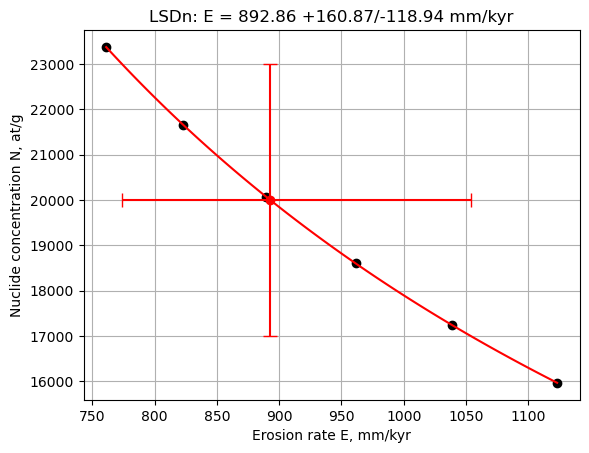

In [32]:
# perform the polynomial fitting and plot results
E, delE, NofE, RMSE, err = (riversand.poly_E_results(sample_data, topostats,
                                                     shielding=shielding, erates=erates, scaling=scaling)
                            )
fig, ax = riversand.plot_polyfit(E, delE, NofE, sample_data, unit=unit)
fig

In [33]:
print("{} : {:.0f} +/- {:.0f} {} ({})".format(sample_data['nuclide'], E*u, delE[1]*u, unit, scaling))

Be-10 : 893 +/- 161 mm/kyr (LSDn)


# 3. Plotting functions

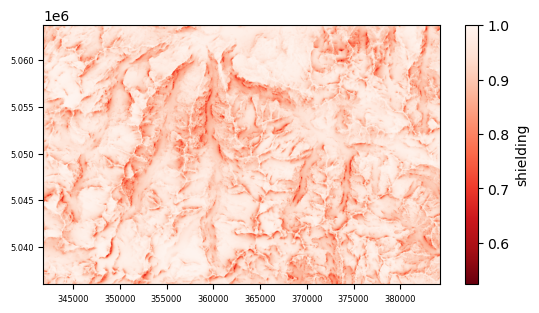

In [34]:
fig, ax = riversand.plot_raster(rv, dtype='shielding')
fig

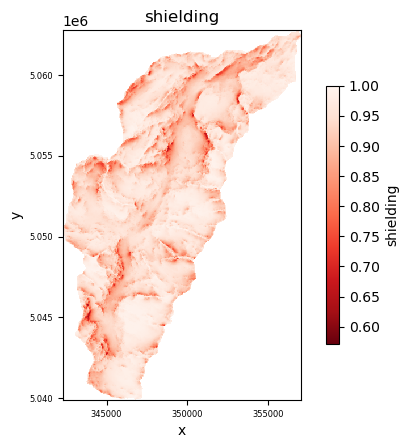

In [35]:
fig, ax = riversand.plot_clipped_raster(clips, dtype='shielding')
fig

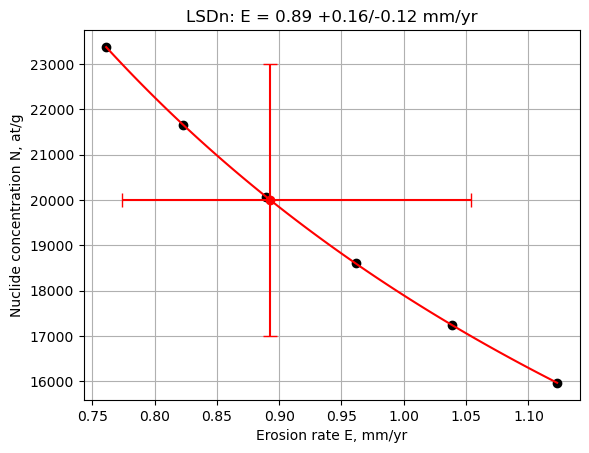

In [36]:
# file name automatically generated from sample_data['name'] and the scaling method used to generate NofE
fig, ax = riversand.plot_polyfit(E, delE, NofE, sample_data)
fig

In [37]:
fig.savefig('test_file.svg') # save plot as vector graphic

# Finally:
### Some comments on the choice of initial erosion rates:
The functions `.process_single_catchment()`and `.process_multi_catchment()` optimize the choice of a suitable set of initial erosion rates `erates`. You can customize the initial erosion rates, even though this is generally not necessary or even useful:

In [38]:
sample_data = rv.samples.iloc[0]

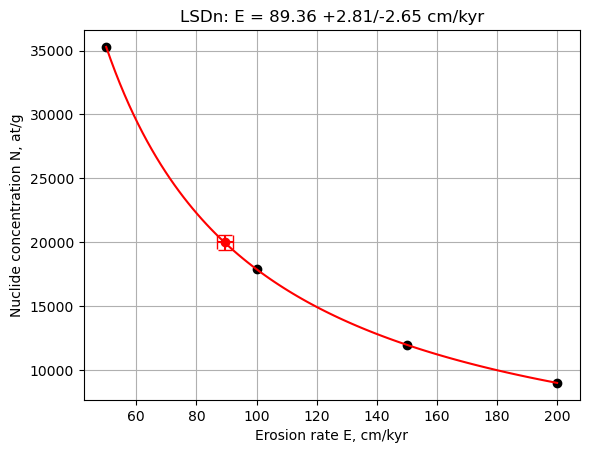

In [39]:
# (1) Custom initial erosion rates:
unit = 'cm/kyr'
erates = [0.05, 0.10, 0.15, 0.20] # cm/yr
E, delE, NofE, RMSE, err = (riversand.poly_E_results(sample_data, topostats,
                                                     shielding=shielding, erates=erates, scaling=scaling)
                            )
fig, ax = riversand.plot_polyfit(E, delE, NofE, sample_data, unit=unit)
fig

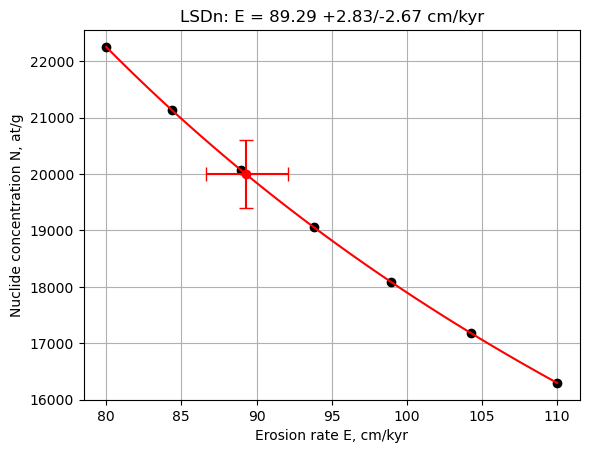

In [40]:
# (2) Using the function .guess_erates() for logarithmically distributed values
erates = riversand.guess_erates(0.08, 0.11, N=7)
E, delE, NofE, RMSE, err = (riversand.poly_E_results(sample_data, topostats,
                                                     shielding=shielding, erates=erates, scaling=scaling)
                           )
fig, ax = riversand.plot_polyfit(E, delE, NofE, sample_data, unit=unit)
fig

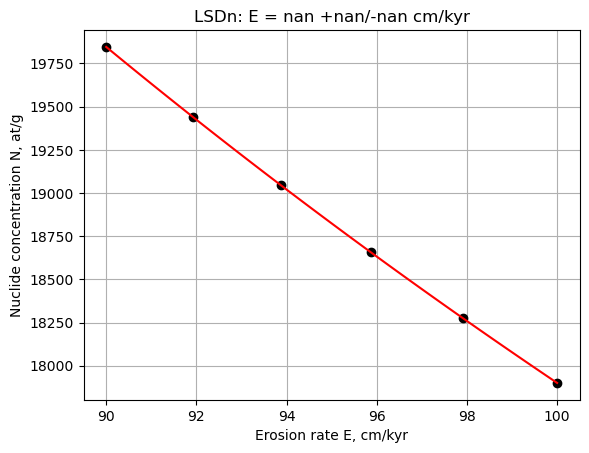

In [41]:
# (3) Using narrower brackets 
erates = riversand.guess_erates(0.09, 0.10, N=6)
E, delE, NofE, RMSE, err = (riversand.poly_E_results(sample_data, topostats,
                                                     shielding=shielding, erates=erates, scaling=scaling)
                           )
fig, ax = riversand.plot_polyfit(E, delE, NofE, sample_data, unit=unit)
fig

In [42]:
# (4) Note that you may get error messages for an unsuitable choice of initial erosion rates
erates = riversand.guess_erates(0.08, 0.09, N=6)
E, delE, NofE, RMSE, err = (riversand.poly_E_results(sample_data, topostats,
                                                     shielding=shielding, erates=erates, scaling=scaling)
                           )
err

[]

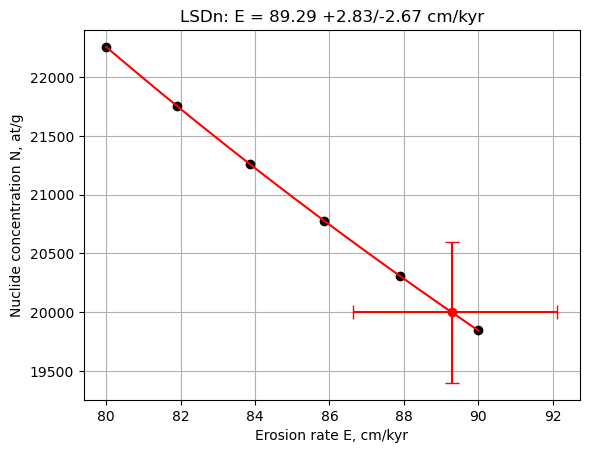

In [43]:
# erosion rate is outside of the range of NofE: nothing much to plot
fig, ax = riversand.plot_polyfit(E, delE, NofE, sample_data, unit=unit)
fig

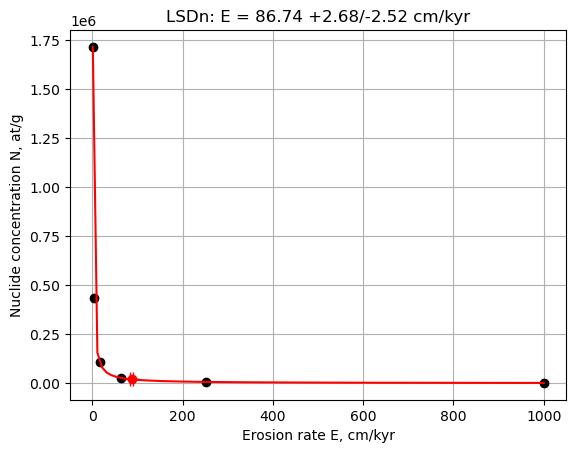

In [44]:
# (5) Unsuitable initial erosion rates may also result in a poor fit of the polynomial function
erates = riversand.guess_erates(0, 1)
E, delE, NofE, RMSE, err = (riversand.poly_E_results(sample_data, topostats,
                                                     shielding=shielding, erates=erates, scaling=scaling)
                           )
fig, ax = riversand.plot_polyfit(E, delE, NofE, sample_data, unit=unit)
fig
#NRMSE = riversand.get_RMSE(NofE)/sample_data['N']

In [45]:
err

['NRMSE = 2.92e-02 suggests a poor fit of the polynomial']

### Extremely high and very low erosion rates
The algorithm becomes unstable for extremely low and extremely high nuclide concentrations; try the following code with concentrations of **N = 100 atoms/gram** or **N = 5E+7 atoms/gram**. It is, of course, highly questionable that such nuclide concentrations reflect a catchmentwide erosion rate...

In [46]:
#extremely high nuclide concentrations:
sample_data = {'N': 5e7, 'delN': 1e6}

# generate initial erosion rates
summary['elevation'] = summary['elevLo']
textline = riversand.get_textline(sample_data, summary, shielding=shielding)
E_Lo = riversand.get_E(textline) # erosion rates in cm/yr
summary['elevation'] = summary['elevHi']
textline = riversand.get_textline(sample_data, summary, shielding=shielding)
E_Hi = riversand.get_E(textline) # erosion rates in cm/yr
erates = riversand.guess_erates(E_Lo, E_Hi, scaling=scaling) # cm/yr

unit = 'mm/kyr'
E, delE, NofE, RMSE, err = (riversand.poly_E_results(sample_data, topostats,
                                                     shielding=shielding, erates=erates, scaling=scaling))
fig, ax = riversand.plot_polyfit(E, delE, NofE, sample_data, unit=unit)

RuntimeError: get_E() : sample appears to be saturated